In [1]:
%env CUDA_VISIBLE_DEVICES=2
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import arviz as az
import aesara
import aesara.tensor as at
import bayesbeta.gp_utils
import math
import numpy as np
import datetime
import toolz
import functools
import multiprocessing.dummy
import matplotlib.pyplot as plt
az.style.use("arviz-white")
aesara.config.floatX = "float64"
if aesara.config.floatX == "float32":
    aesara.config.warn_float64 = "raise"

env: CUDA_VISIBLE_DEVICES=2


/home/ferres/.miniconda3/envs/moex/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/ferres/dev/pymc3/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
data = pd.read_csv("returns.csv", parse_dates=["TRADEDATE"])

In [3]:
pivot = data.pivot_table(index="TRADEDATE", columns="SECID", values="CLOSE_PCT").fillna(0)
pivot = pivot.iloc[-500:]

In [4]:
class NormalNonZero(pm.Normal):
    rv_op = pm.Normal.rv_op
    def logp(value, mu, sigma):
        res = (
            -0.5 * at.pow((value - mu) / sigma, 2)
            - at.log(at.sqrt(2.0 * np.pi))
            - at.log(sigma)
        )
        return at.switch(at.eq(value, 0), pm.floatX(0.), res)

## Priors
* Returns
    * https://www.theglobaleconomy.com/rankings/Stock_market_return/ tells that market returns range between [-30% - +40%]
        * Stock market return is the growth rate of annual average stock market index. Annual average stock market index is constructed by taking the average of the daily stock market indexes available at Bloomberg.
* Risk
    * https://www.theglobaleconomy.com/rankings/Stock_price_volatility/ tells that market volatility ranges between [3.5% - 65%]
        * The stock price volatility index is the 360-day standard deviation of the return on the national stock market index.

In [5]:
year_mean = np.array([-0.3, 0.4])
year_std = np.array([.035, 0.65])
day_mean = (1 + year_mean) ** (1/250) - 1
day_log_std = np.log(year_std) - 2 # / 2 is a bit arbitrary

In [6]:
day_log_std

array([-5.35240722, -2.43078292])

In [7]:
with aesara.config.change_flags(warn_float64="ignore", mode=aesara.compile.mode.FAST_RUN):
    day_mean_prior = pm.find_constrained_prior(pm.Normal, *day_mean, init_guess=dict(mu=np.mean(day_mean), sigma=0.001))
    day_mean_prior = toolz.valmap(pm.floatX, day_mean_prior)
    day_log_std_prior = pm.find_constrained_prior(pm.Normal, *day_log_std, init_guess=dict(mu=np.mean(day_log_std), sigma=1))
    day_log_std_prior = toolz.valmap(pm.floatX, day_log_std_prior)

In [8]:
print(day_mean_prior)
print(day_log_std_prior)

{'mu': -3.9443730030717574e-05, 'sigma': 0.0007072776922472779}
{'mu': -3.89159506587998, 'sigma': 0.7453260485950619}


In [9]:
def mu_sigma_reparam(Dist, name, *, transform=lambda x: x, **params, ):
    mu = params.pop("mu", 0)
    sigma = params.pop("sigma", 1)
    params["mu"] = 0
    params["sigma"] = 1
    with pm.Model(name):
        raw = Dist("raw", **params)
    return pm.Deterministic(name, transform(raw * sigma + mu), dims=params.get("dims"))

In [38]:
with pm.Model(coords=dict(ticker=pivot.columns, time=pivot.index)) as model:
    with pm.Model("return"):
        with pm.Model("market"):
            sigma = day_mean_prior["sigma"]
            mu = day_mean_prior["mu"]
            market_mean = mu_sigma_reparam(pm.Normal, "mu", mu=mu, sigma=sigma)
        h1 = pm.LogNormal("h1")
        ticker_mean = mu_sigma_reparam(
            pm.Normal, "mu", 
            mu=market_mean, 
            sigma=sigma * h1, 
            dims="ticker")
    with pm.Model("risk"):
        with pm.Model("market"):
            sigma = day_log_std_prior["sigma"]
            mu = day_log_std_prior["mu"]
            market_log_std = mu_sigma_reparam(pm.Normal, "sigma", mu=mu, sigma=sigma)
        h1 = pm.LogNormal("h1")
        h2 = pm.LogNormal("h2", -1, dims="ticker")
        ticker_log_std = mu_sigma_reparam(
            pm.Normal, "sigma", 
            mu=market_log_std, 
            sigma=sigma * h1, 
            dims="ticker",
        )
        gp_std = bayesbeta.gp_utils.bspline_gp(
            sparsity=7, 
            length_scale=14, 
            mean=ticker_log_std, 
            scale=sigma * h2, 
            link=at.exp, 
            dims=("ticker", ),
            sparse=False
        )
    obs_data = pm.ConstantData("obs_data", np.log(pivot+1), dims=("time", "ticker"))
    NormalNonZero("obs", ticker_mean - gp_std ** 2 / 2, gp_std, observed=obs_data)

In [39]:
time_started = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=3)))
with model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        chains=2,
        chain_method="vectorized", postprocessing_backend="cpu")
    trace.extend(pm.sample_prior_predictive())
time_ended = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=3)))
az.to_netcdf(trace, time_started.strftime("black_shoulez_%Y-%m-%d:%H.nc"))

Compiling...


/home/ferres/dev/pymc3/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:01.640516
Sampling...


sample: 100%|██████████| 2000/2000 [39:20<00:00,  1.18s/it]


Sampling time =  0:39:21.179922
Transforming variables...
Transformation time =  0:00:01.689598


/home/ferres/dev/pymc3/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


'black_shoulez_2022-04-06:22.nc'

In [40]:
trace.posterior

<xarray.Dataset>
Dimensions:                   (chain: 2, draw: 1000, ticker: 253,
                               risk::latent_time: 71, time: 500)
Coordinates:
  * chain                     (chain) int64 0 1
  * draw                      (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * ticker                    (ticker) <U5 'ABRD' 'AFKS' ... 'ZILL' 'ZVEZ'
  * risk::latent_time         (risk::latent_time) datetime64[ns] 2019-07-31 ....
  * time                      (time) datetime64[ns] 2019-07-31 ... 2020-12-11
Data variables: (12/13)
    return::market::mu::raw   (chain, draw) float64 0.06756 0.1058 ... 0.06341
    return::mu::raw           (chain, draw, ticker) float64 -0.2714 ... -0.2431
    risk::market::sigma::raw  (chain, draw) float64 -0.7453 -0.7457 ... -0.7158
    risk::sigma::raw          (chain, draw, ticker) float64 -0.5119 ... 0.1367
    risk::latent_rotated_     (chain, draw, risk::latent_time, ticker) float64 ...
    return::h1                (chain, draw) float64 0.5222 0.4999 ... 0.4959
    ...                        ...
    risk::h2                  (chain, draw, ticker) float64 1.789 ... 0.8789
    return::market::mu        (chain, draw) float64 8.339e-06 ... 5.406e-06
    return::mu                (chain, draw, ticker) float64 -9.188e-05 ... -7...
    risk::market::sigma       (chain, draw) float64 -4.447 -4.447 ... -4.425
    risk::sigma               (chain, draw, ticker) float64 -4.506 ... -4.407
    risk::gp                  (chain, draw, time, ticker) float64 0.005413 .....
Attributes:
    created_at:     2022-04-06T20:38:42.938071
    arviz_version:  0.12.0

array([[<AxesSubplot:title={'center':'risk::h2'}>,
        <AxesSubplot:title={'center':'risk::h2'}>],
       [<AxesSubplot:title={'center':'risk::h1'}>,
        <AxesSubplot:title={'center':'risk::h1'}>],
       [<AxesSubplot:title={'center':'return::h1'}>,
        <AxesSubplot:title={'center':'return::h1'}>],
       [<AxesSubplot:title={'center':'return::market::mu'}>,
        <AxesSubplot:title={'center':'return::market::mu'}>],
       [<AxesSubplot:title={'center':'risk::market::sigma'}>,
        <AxesSubplot:title={'center':'risk::market::sigma'}>]],
      dtype=object)

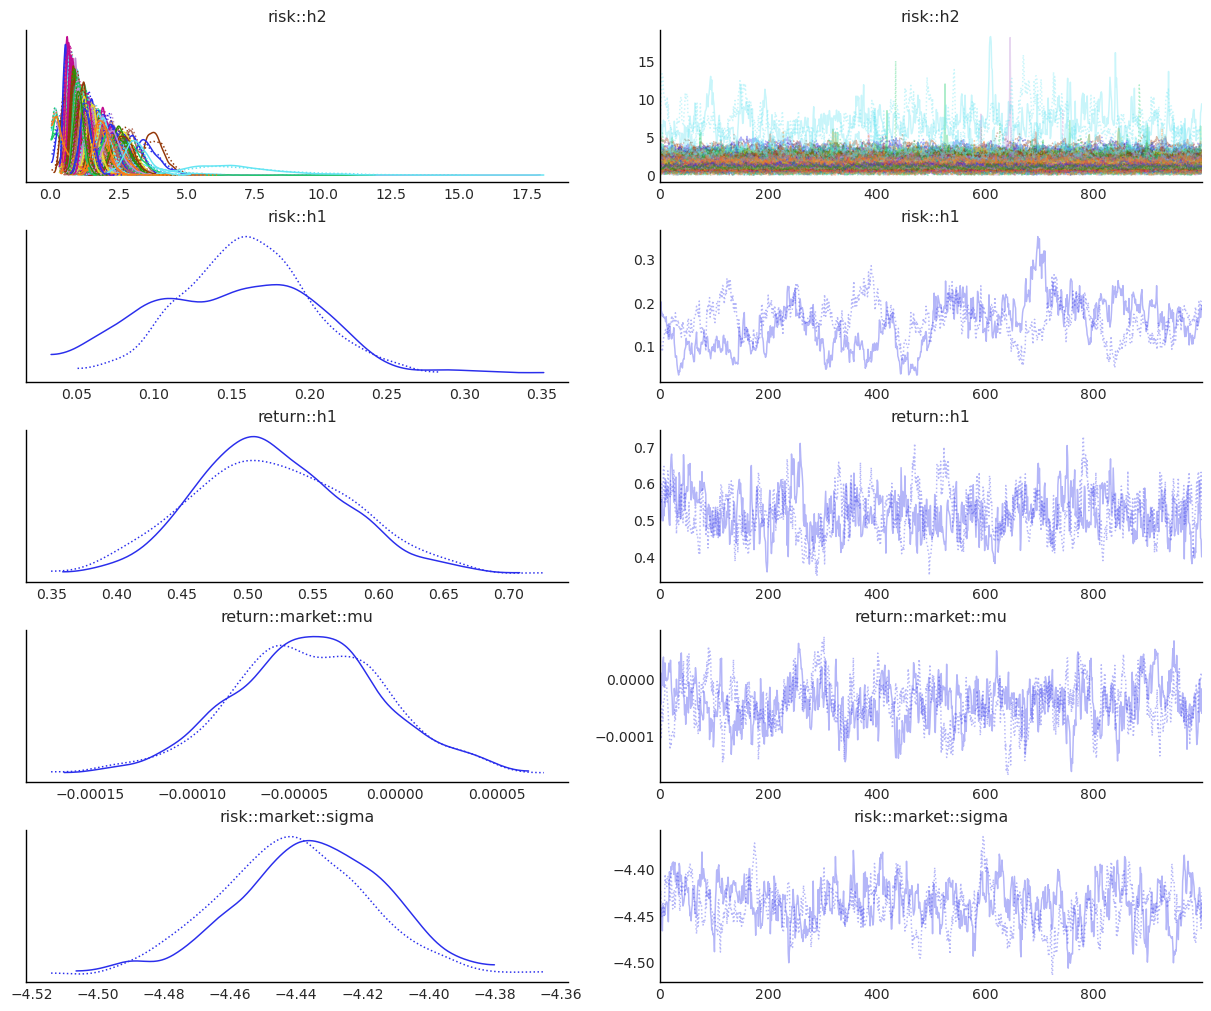

In [41]:
az.plot_trace(trace, var_names=["risk::h2", "risk::h1", "return::h1", "return::market::mu", "risk::market::sigma"])

/home/ferres/.miniconda3/envs/moex/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


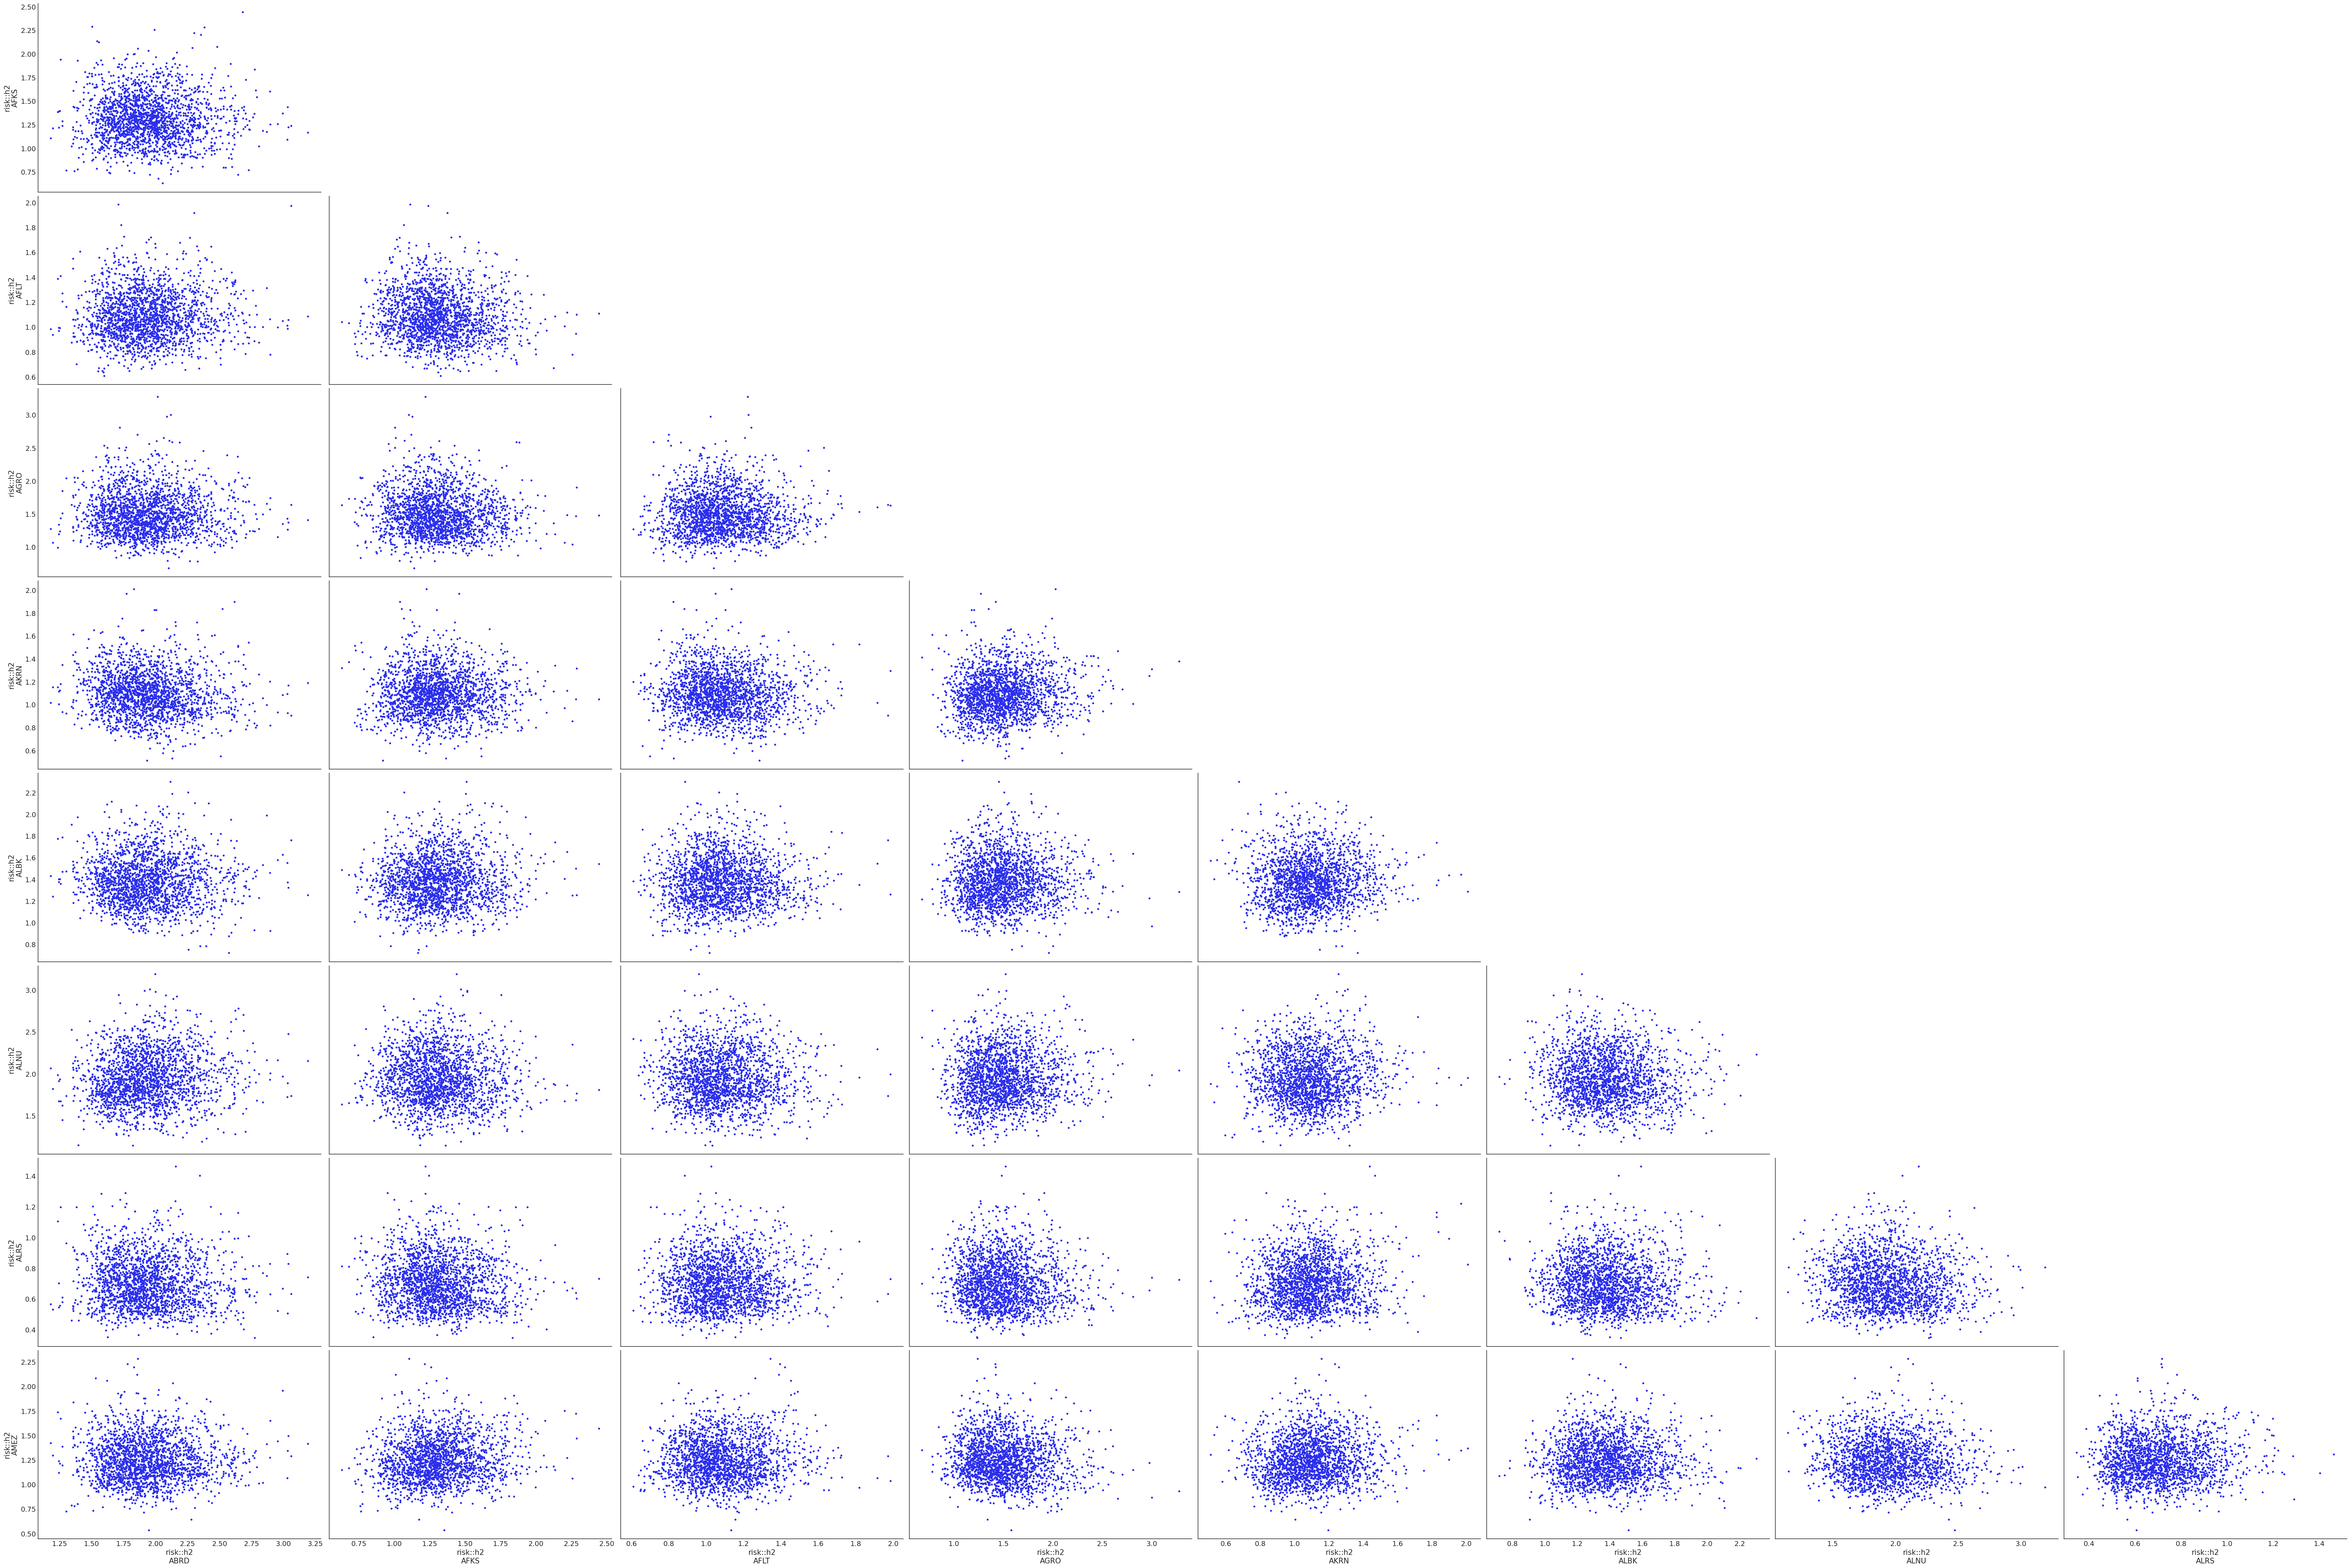

In [26]:
az.plot_pair(trace, var_names=["risk::h2"]);

In [33]:
import scipy.stats
scipy.stats.lognorm.fit(trace.posterior["risk::h2"].mean(["chain", "draw"]))

(0.37524727809720654, 0.016638890249797304, 1.4963484051299247)

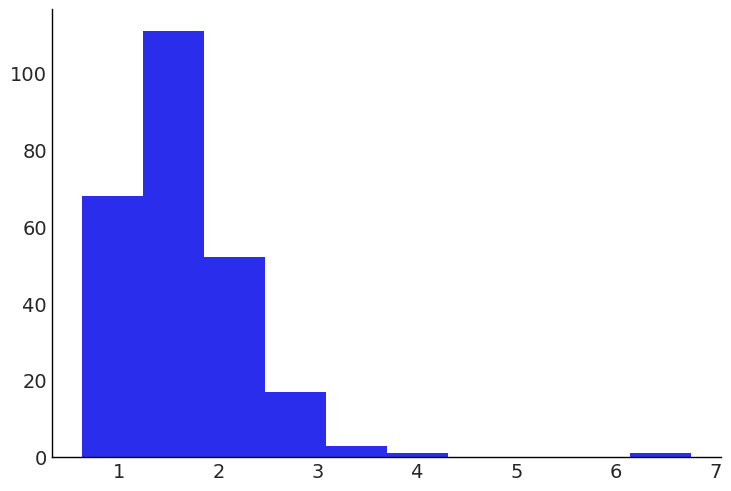

In [25]:
plt.hist(trace.posterior["risk::h2"].mean(["chain", "draw"]));

/home/ferres/.miniconda3/envs/moex/lib/python3.9/site-packages/arviz/plots/distcomparisonplot.py:157: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of subplots to plot (759), generating only 39 plots
  warnings.warn(


array([[<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nABRD'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAFKS'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAFLT'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAGRO'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAKRN'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nALBK'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nALNU'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nALRS'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAMEZ'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAPTK'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='risk::h2\nAQUA'>],
       [<AxesSubplot:>, <AxesSub

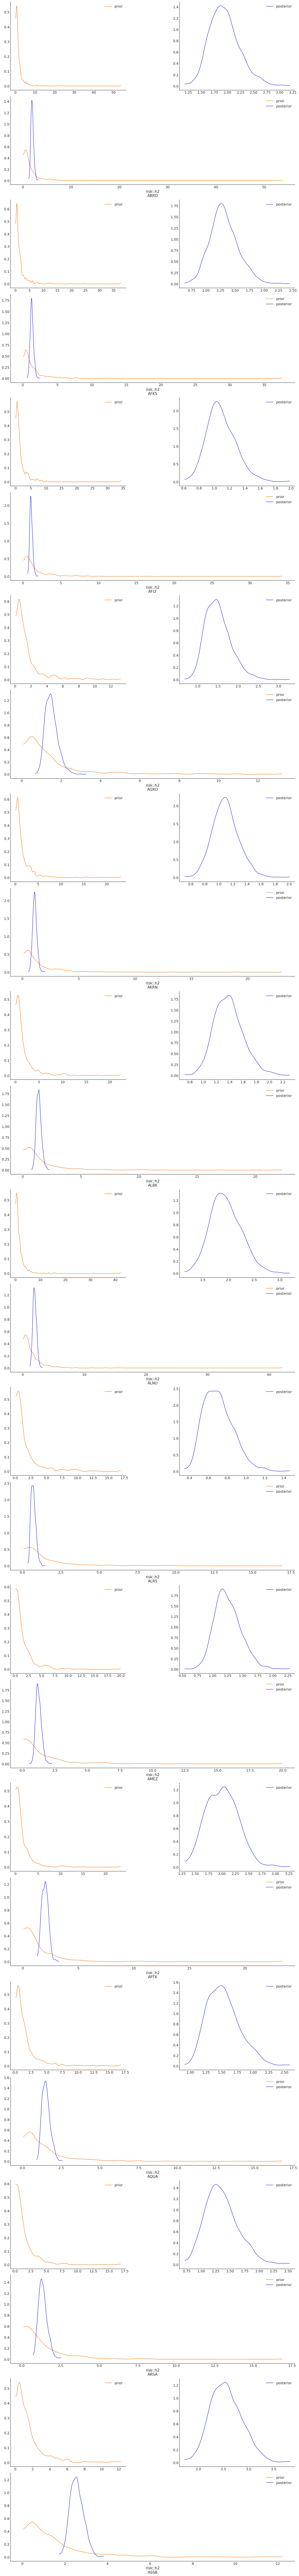

In [21]:
az.plot_dist_comparison(trace, var_names=["risk::h2"])

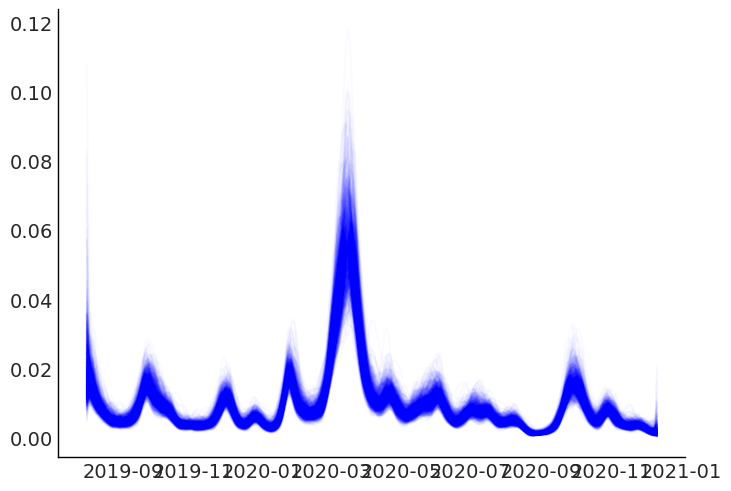

In [ ]:
plt.plot(trace.posterior.coords["time"], trace.posterior["risk::gp"].sel(ticker="APTK", chain=0).values.T, alpha=0.02, color="b");

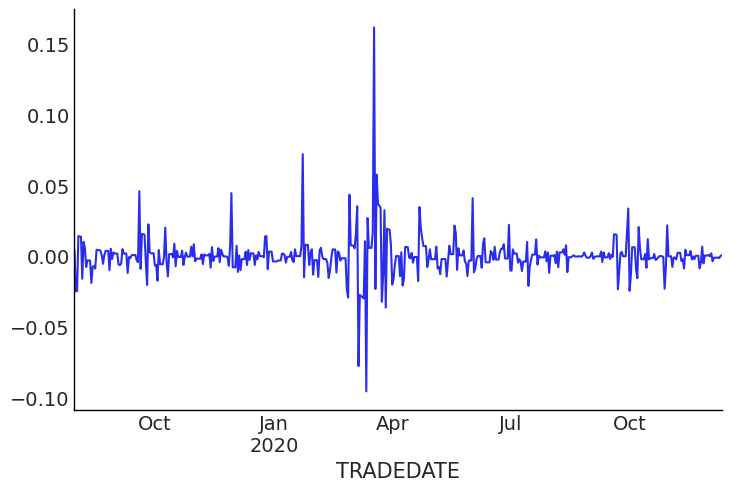

In [ ]:
pivot["APTK"].plot();